In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = 'MAPE_ExtendedRange_NoneLeftOut_Combined1Distribution'
base_name = 'ExtendedRange_NoneLeftOut_Combined1Distribution'    # This is the dataset base name

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        
        # Compute the Mean Absolute Percentage Error
        loss = torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
        return loss

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = MAPELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 5687125.4141, Test Loss: 799476.4098
Epoch [2/1000], Train Loss: 2496259.0851, Test Loss: 646735.8809
Epoch [3/1000], Train Loss: 2106918.2195, Test Loss: 498315.5304
Epoch [4/1000], Train Loss: 1976104.3691, Test Loss: 434773.6722
Epoch [5/1000], Train Loss: 1767252.8648, Test Loss: 425594.8850
Epoch [6/1000], Train Loss: 1739534.0284, Test Loss: 428507.5196
Epoch [7/1000], Train Loss: 1670904.8843, Test Loss: 412378.0193
Epoch [8/1000], Train Loss: 1647226.2229, Test Loss: 418491.5940
Epoch [9/1000], Train Loss: 1598379.3246, Test Loss: 404570.8894
Epoch [10/1000], Train Loss: 1571418.4348, Test Loss: 387645.6178
Epoch [11/1000], Train Loss: 1553530.3932, Test Loss: 377424.5301
Epoch [12/1000], Train Loss: 1554968.8989, Test Loss: 397523.5742
Epoch [13/1000], Train Loss: 1546843.3303, Test Loss: 382553.2260
Epoch [14/1000], Train Loss: 1511760.4363, Test Loss: 374206.9167
Epoch [15/1000], Train Loss: 149905

Epoch [125/1000], Train Loss: 1299347.6556, Test Loss: 331074.9885
Epoch [126/1000], Train Loss: 1298013.0258, Test Loss: 330815.6461
Epoch [127/1000], Train Loss: 1296703.8440, Test Loss: 329315.9845
Epoch [128/1000], Train Loss: 1297936.2889, Test Loss: 331371.3450
Epoch [129/1000], Train Loss: 1298137.9619, Test Loss: 328419.8770
Epoch [130/1000], Train Loss: 1297209.2773, Test Loss: 330840.7769
Epoch [131/1000], Train Loss: 1296706.7110, Test Loss: 331575.7876
Epoch [132/1000], Train Loss: 1296990.2110, Test Loss: 332789.4565
Epoch [133/1000], Train Loss: 1295853.1693, Test Loss: 331119.8152
Epoch [134/1000], Train Loss: 1294595.6382, Test Loss: 330037.9857
Epoch [135/1000], Train Loss: 1296547.2947, Test Loss: 332610.5362
Epoch [136/1000], Train Loss: 1294826.2450, Test Loss: 331058.3170
Epoch [137/1000], Train Loss: 1294103.0527, Test Loss: 332140.7332
Epoch [138/1000], Train Loss: 1296176.5049, Test Loss: 332470.5947
Epoch [139/1000], Train Loss: 1298359.9376, Test Loss: 332237.

In [11]:
np.array(test_losses).min()

328419.87704467773

In [12]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [13]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [14]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[ 4.0752e+00,  2.3707e-01,  5.4667e-01,  5.3727e-02,  6.5862e-01,
          2.9162e-01,  1.3751e-01,  1.8879e-01,  2.4669e-01,  5.5468e-01,
          3.7397e-01,  7.9551e-01,  2.4685e+00,  8.1659e-01,  5.8421e-02,
         -9.0797e-02,  7.8749e-01,  5.7135e-01,  4.0858e-01,  2.1583e-01,
          8.1151e-01,  1.4292e+00,  4.4486e-01,  2.7233e-01,  5.9892e-01,
          2.7974e-01,  9.0199e-02, -9.9097e-03,  4.4573e-01,  6.5631e-01,
          1.7984e+00,  5.0183e-01,  6.7486e-01, -8.8926e-02,  2.3417e-01,
          4.6680e-01,  3.0682e-01,  2.4693e-01,  2.2858e-01, -6.9765e-02,
          3.1849e-03,  1.7935e+00,  4.5411e-01,  6.9661e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
Prediction.detach().cpu().numpy()[0]

array([ 4.0751719e+00,  2.3706980e-01,  5.4666811e-01,  5.3726584e-02,
        6.5861702e-01,  2.9161811e-01,  1.3751137e-01,  1.8878946e-01,
        2.4669020e-01,  5.5467904e-01,  3.7397102e-01,  7.9551232e-01,
        2.4685020e+00,  8.1659114e-01,  5.8420502e-02, -9.0797365e-02,
        7.8748769e-01,  5.7135427e-01,  4.0857670e-01,  2.1582551e-01,
        8.1151098e-01,  1.4291942e+00,  4.4486126e-01,  2.7233014e-01,
        5.9891784e-01,  2.7974051e-01,  9.0198696e-02, -9.9097276e-03,
        4.4572809e-01,  6.5630668e-01,  1.7983572e+00,  5.0182503e-01,
        6.7486203e-01, -8.8926010e-02,  2.3416829e-01,  4.6680328e-01,
        3.0682409e-01,  2.4692902e-01,  2.2857572e-01, -6.9764845e-02,
        3.1849351e-03,  1.7935426e+00,  4.5410553e-01,  6.9660985e-01],
      dtype=float32)

In [16]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  82.03590986376358


In [17]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
321.02  - Concentrations: 0.004999999888241291
15.81  - Concentrations: 0.02500000037252903
78.94  - Concentrations: 0.10000000149011612
91.57  - Concentrations: 0.25
95.78  - Concentrations: 0.5
97.91  - Concentrations: 1.0
99.23  - Concentrations: 2.5
99.74  - Concentrations: 10.0
84.47  - Concentrations: 20.0


In [18]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  102.872154
--------------------
99.65  - Min Value: 0.6783  - Mean Value: 9.2
148.15  - Min Value: 0.0096  - Mean Value: 10.3
99.59  - Min Value: 0.147  - Mean Value: 10.5
99.51  - Min Value: 0.5572  - Mean Value: 8.5
95.17  - Min Value: 1.3567  - Mean Value: 10.6
99.41  - Min Value: 0.6332  - Mean Value: 10.9
92.57  - Min Value: 0.7017  - Mean Value: 11.0
99.37  - Min Value: 0.3674  - Mean Value: 8.9
99.69  - Min Value: 0.8387  - Mean Value: 9.8
95.61  - Min Value: 1.0913  - Mean Value: 11.1


In [19]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  78.398254
--------------------
79.92  - Min Value: 0.0111  - Mean Value: 0.1
74.93  - Min Value: 0.0103  - Mean Value: 0.1
76.68  - Min Value: 0.0153  - Mean Value: 0.1
72.22  - Min Value: 0.0117  - Mean Value: 0.1
79.15  - Min Value: 0.0089  - Mean Value: 0.1
80.91  - Min Value: 0.0075  - Mean Value: 0.1
75.99  - Min Value: 0.0117  - Mean Value: 0.1
86.37  - Min Value: 0.0052  - Mean Value: 0.1
80.6  - Min Value: 0.008  - Mean Value: 0.1
77.22  - Min Value: 0.0134  - Mean Value: 0.1


In [20]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  83.87969
--------------------
81.15  - Min Value: 0.008  - Mean Value: 0.8
85.91  - Min Value: 0.009  - Mean Value: 0.9
81.65  - Min Value: 0.0138  - Mean Value: 1.5
85.35  - Min Value: 0.0107  - Mean Value: 0.7
84.51  - Min Value: 0.0191  - Mean Value: 0.7
80.29  - Min Value: 0.0186  - Mean Value: 0.8
83.19  - Min Value: 0.0175  - Mean Value: 0.8
87.34  - Min Value: 0.0238  - Mean Value: 1.3
87.0  - Min Value: 0.0168  - Mean Value: 0.7
82.42  - Min Value: 0.0171  - Mean Value: 0.9


In [21]:
APEs[0]

[tensor(92.4033),
 tensor(76.7638),
 tensor(98.0737),
 tensor(56.9187),
 tensor(16.7511),
 tensor(91.5235),
 tensor(169.6845),
 tensor(96.1837),
 tensor(83.6832),
 tensor(87.2551),
 tensor(97.2851),
 tensor(54.5186),
 tensor(98.9453),
 tensor(97.4360),
 tensor(54.3292),
 tensor(90.8370),
 tensor(94.3737),
 tensor(38.5949),
 tensor(96.4059),
 tensor(59.5084),
 tensor(65.8190),
 tensor(99.5587),
 tensor(72.1137),
 tensor(45.3879),
 tensor(98.1246),
 tensor(99.0015),
 tensor(77.6234),
 tensor(90.6076),
 tensor(98.6294),
 tensor(61.2824),
 tensor(99.8005),
 tensor(92.7702),
 tensor(92.1407),
 tensor(84.5178),
 tensor(77.9354),
 tensor(64.0405),
 tensor(27.8248),
 tensor(96.3018),
 tensor(96.5804),
 tensor(77.0263),
 tensor(27.5382),
 tensor(99.5461),
 tensor(91.7859),
 tensor(83.0409)]

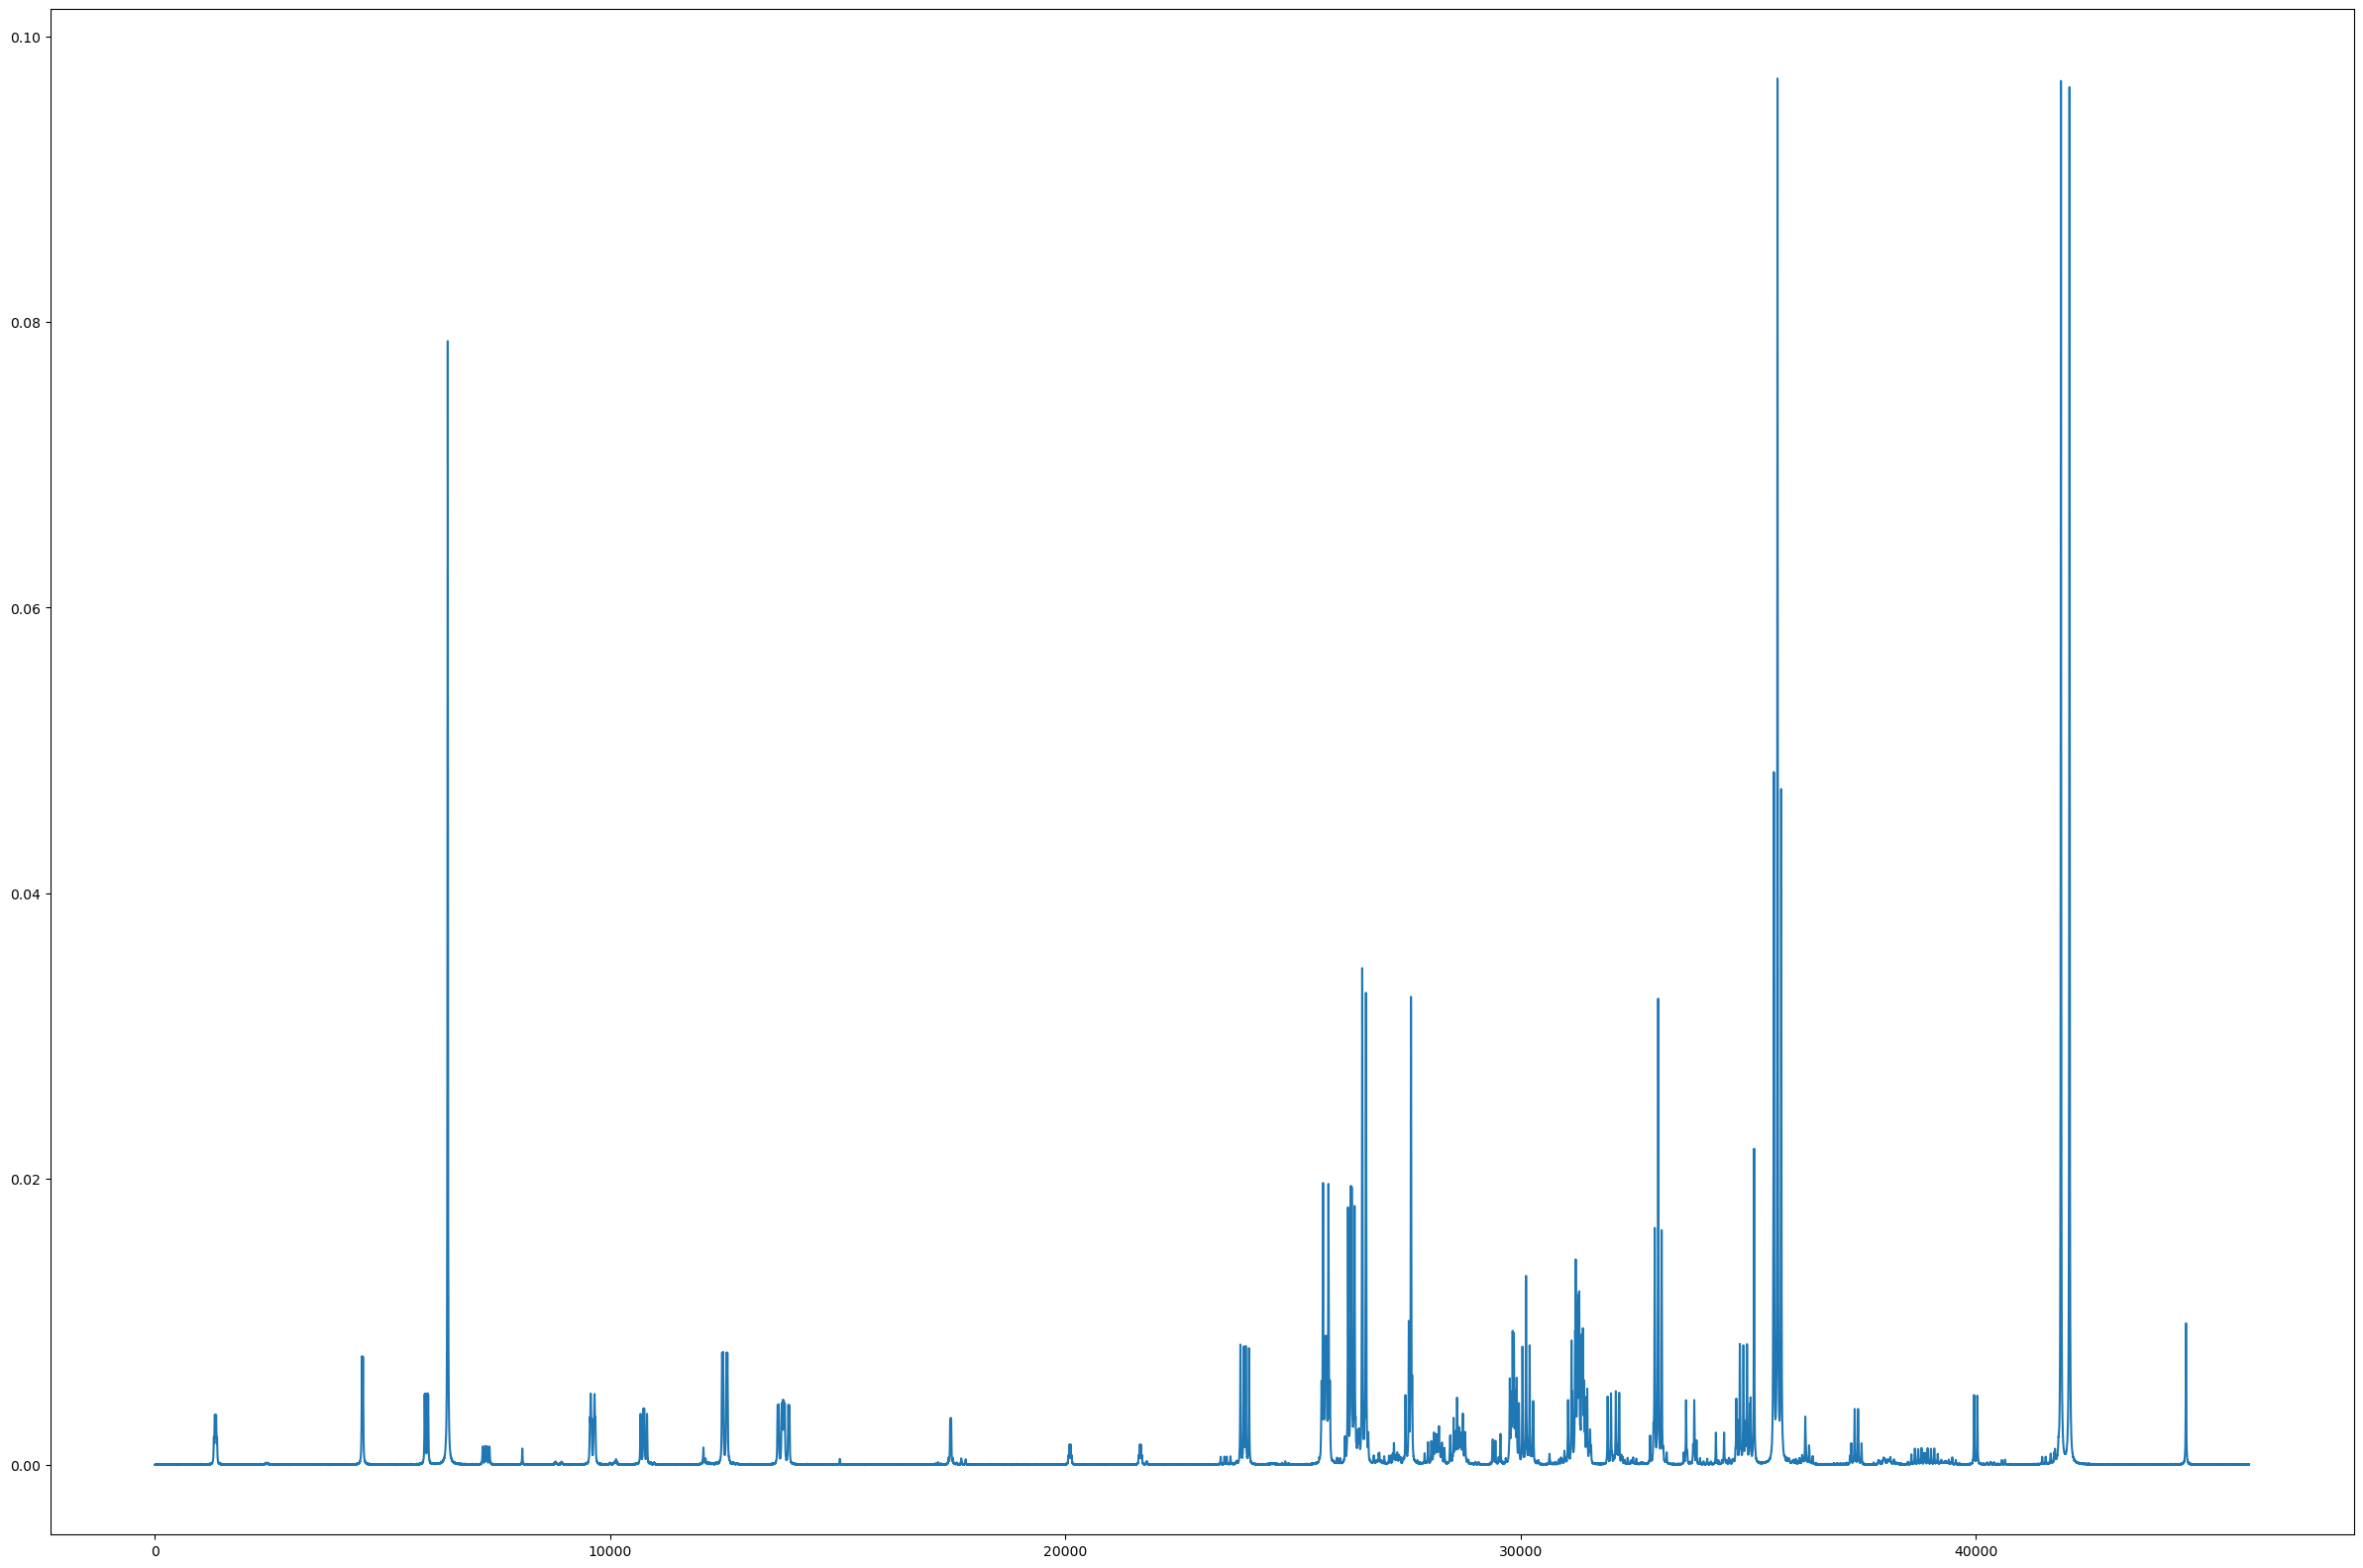

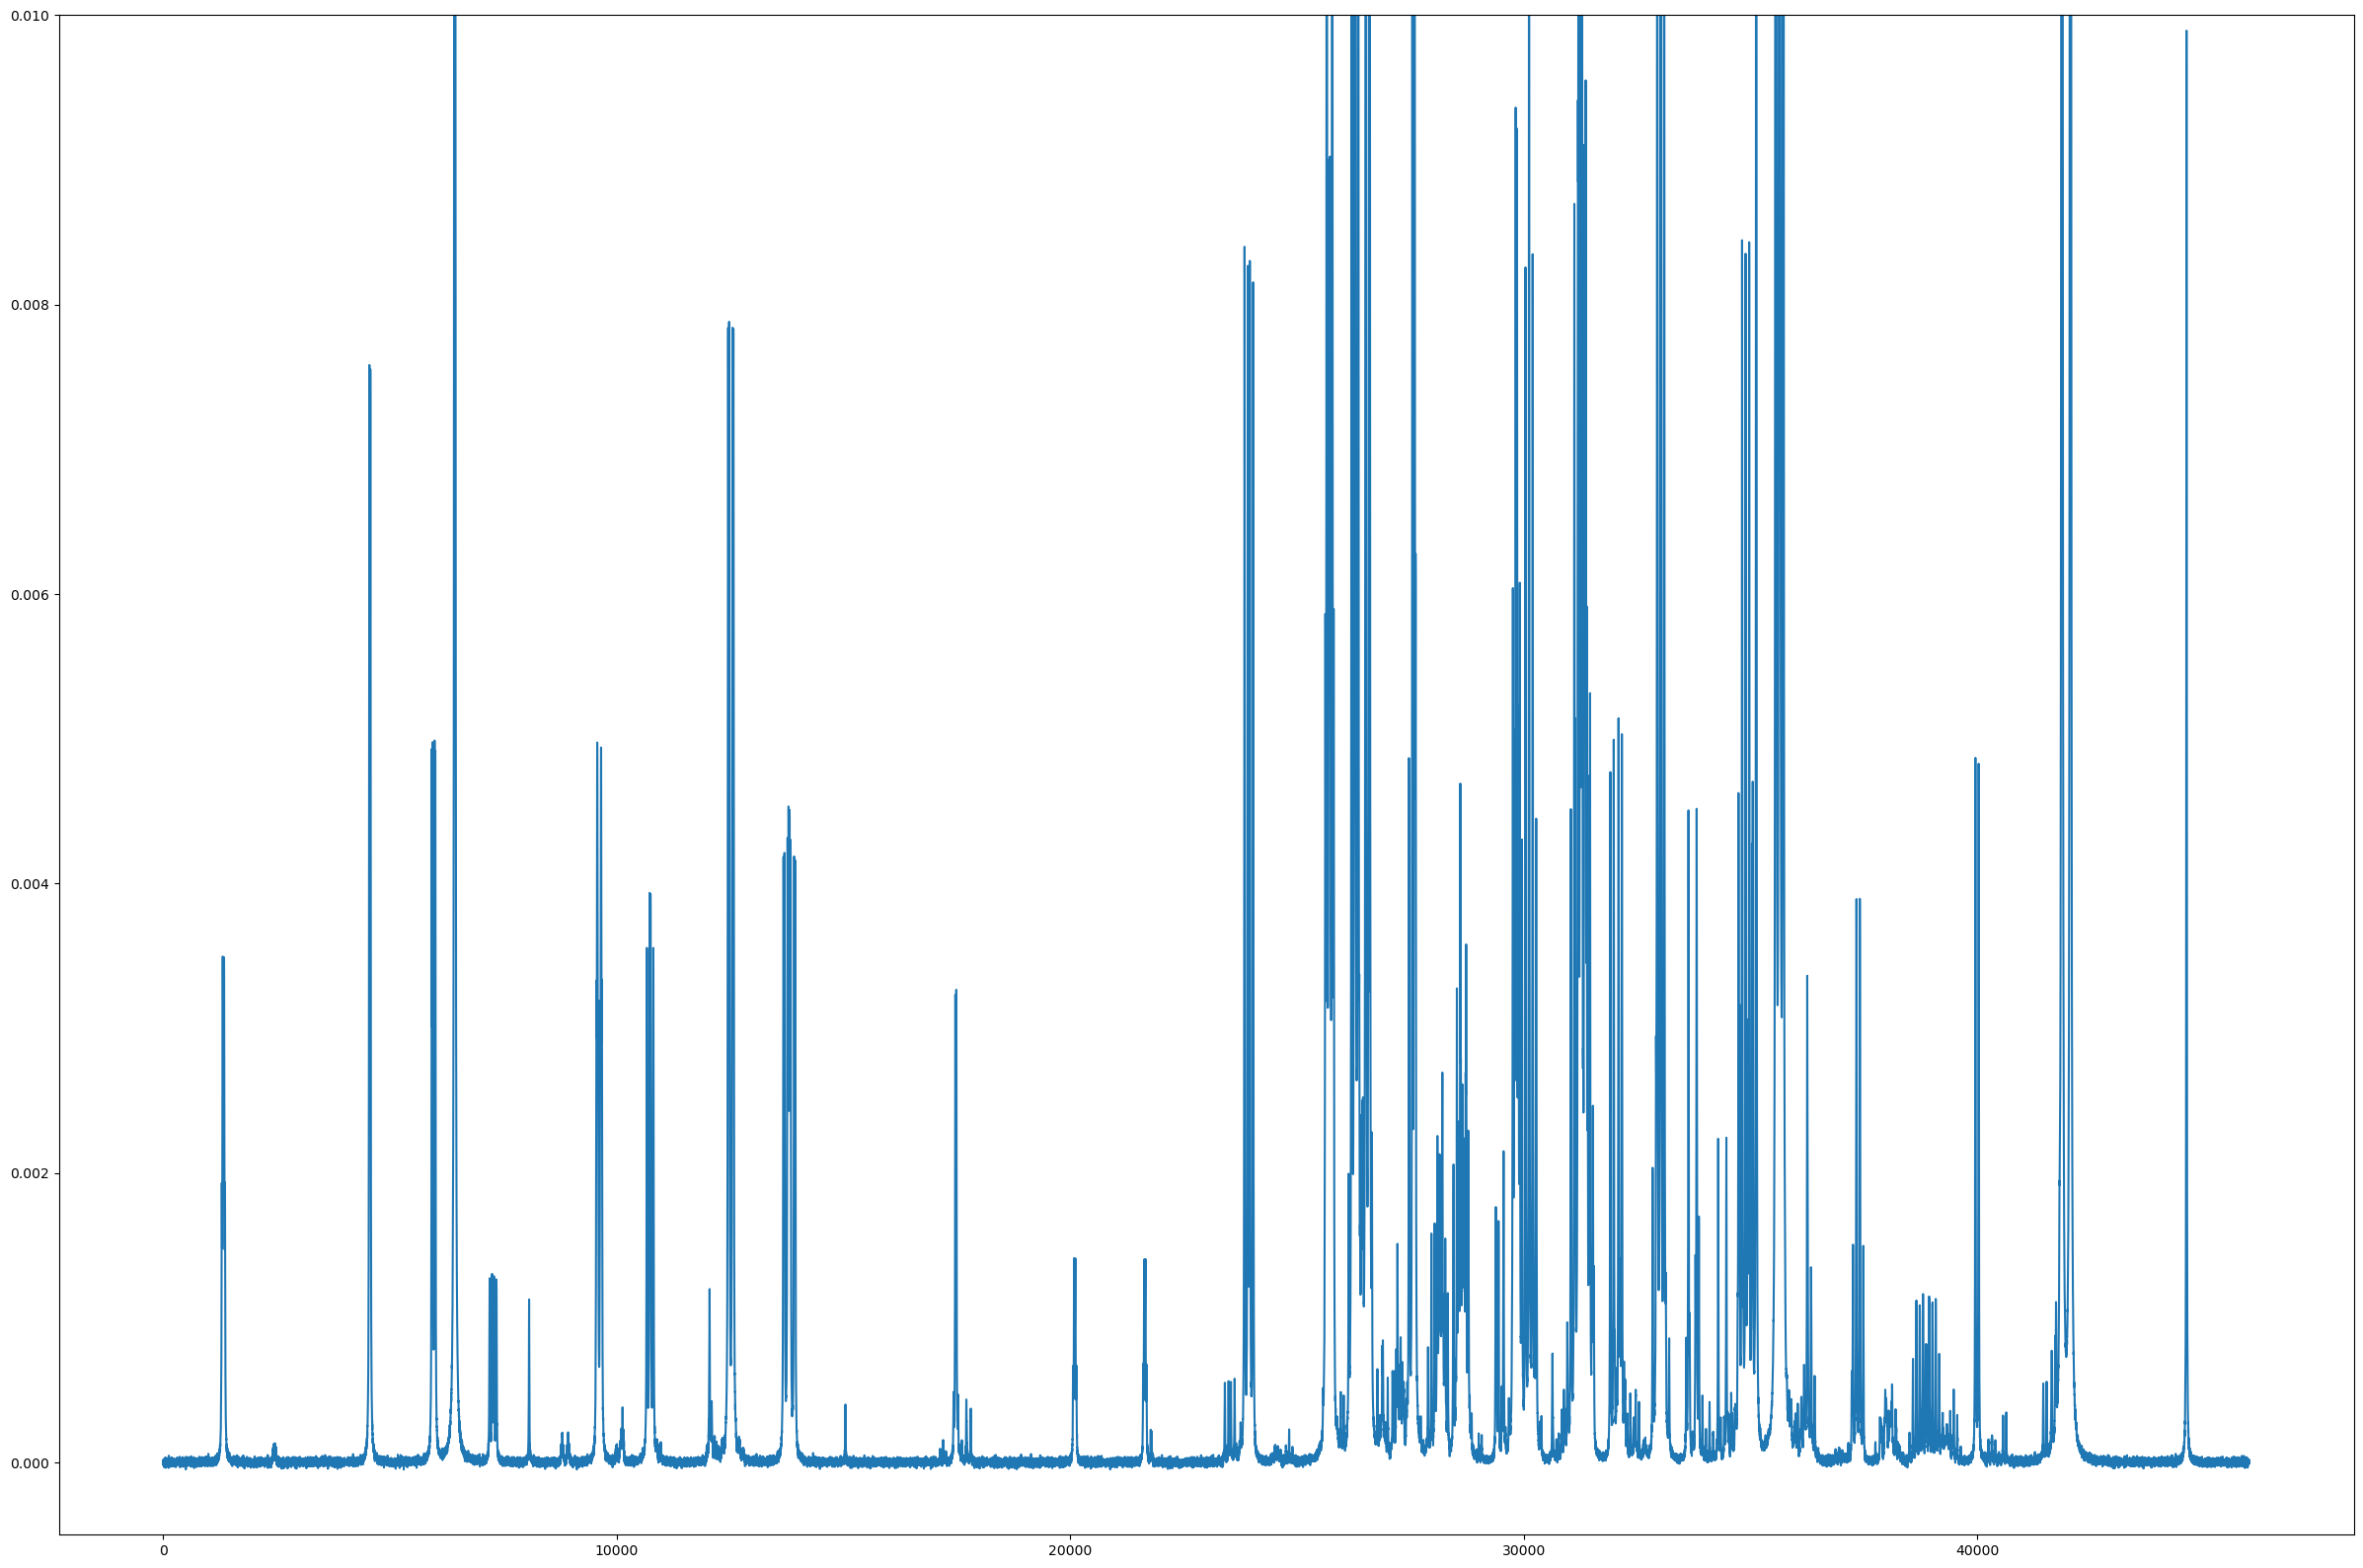

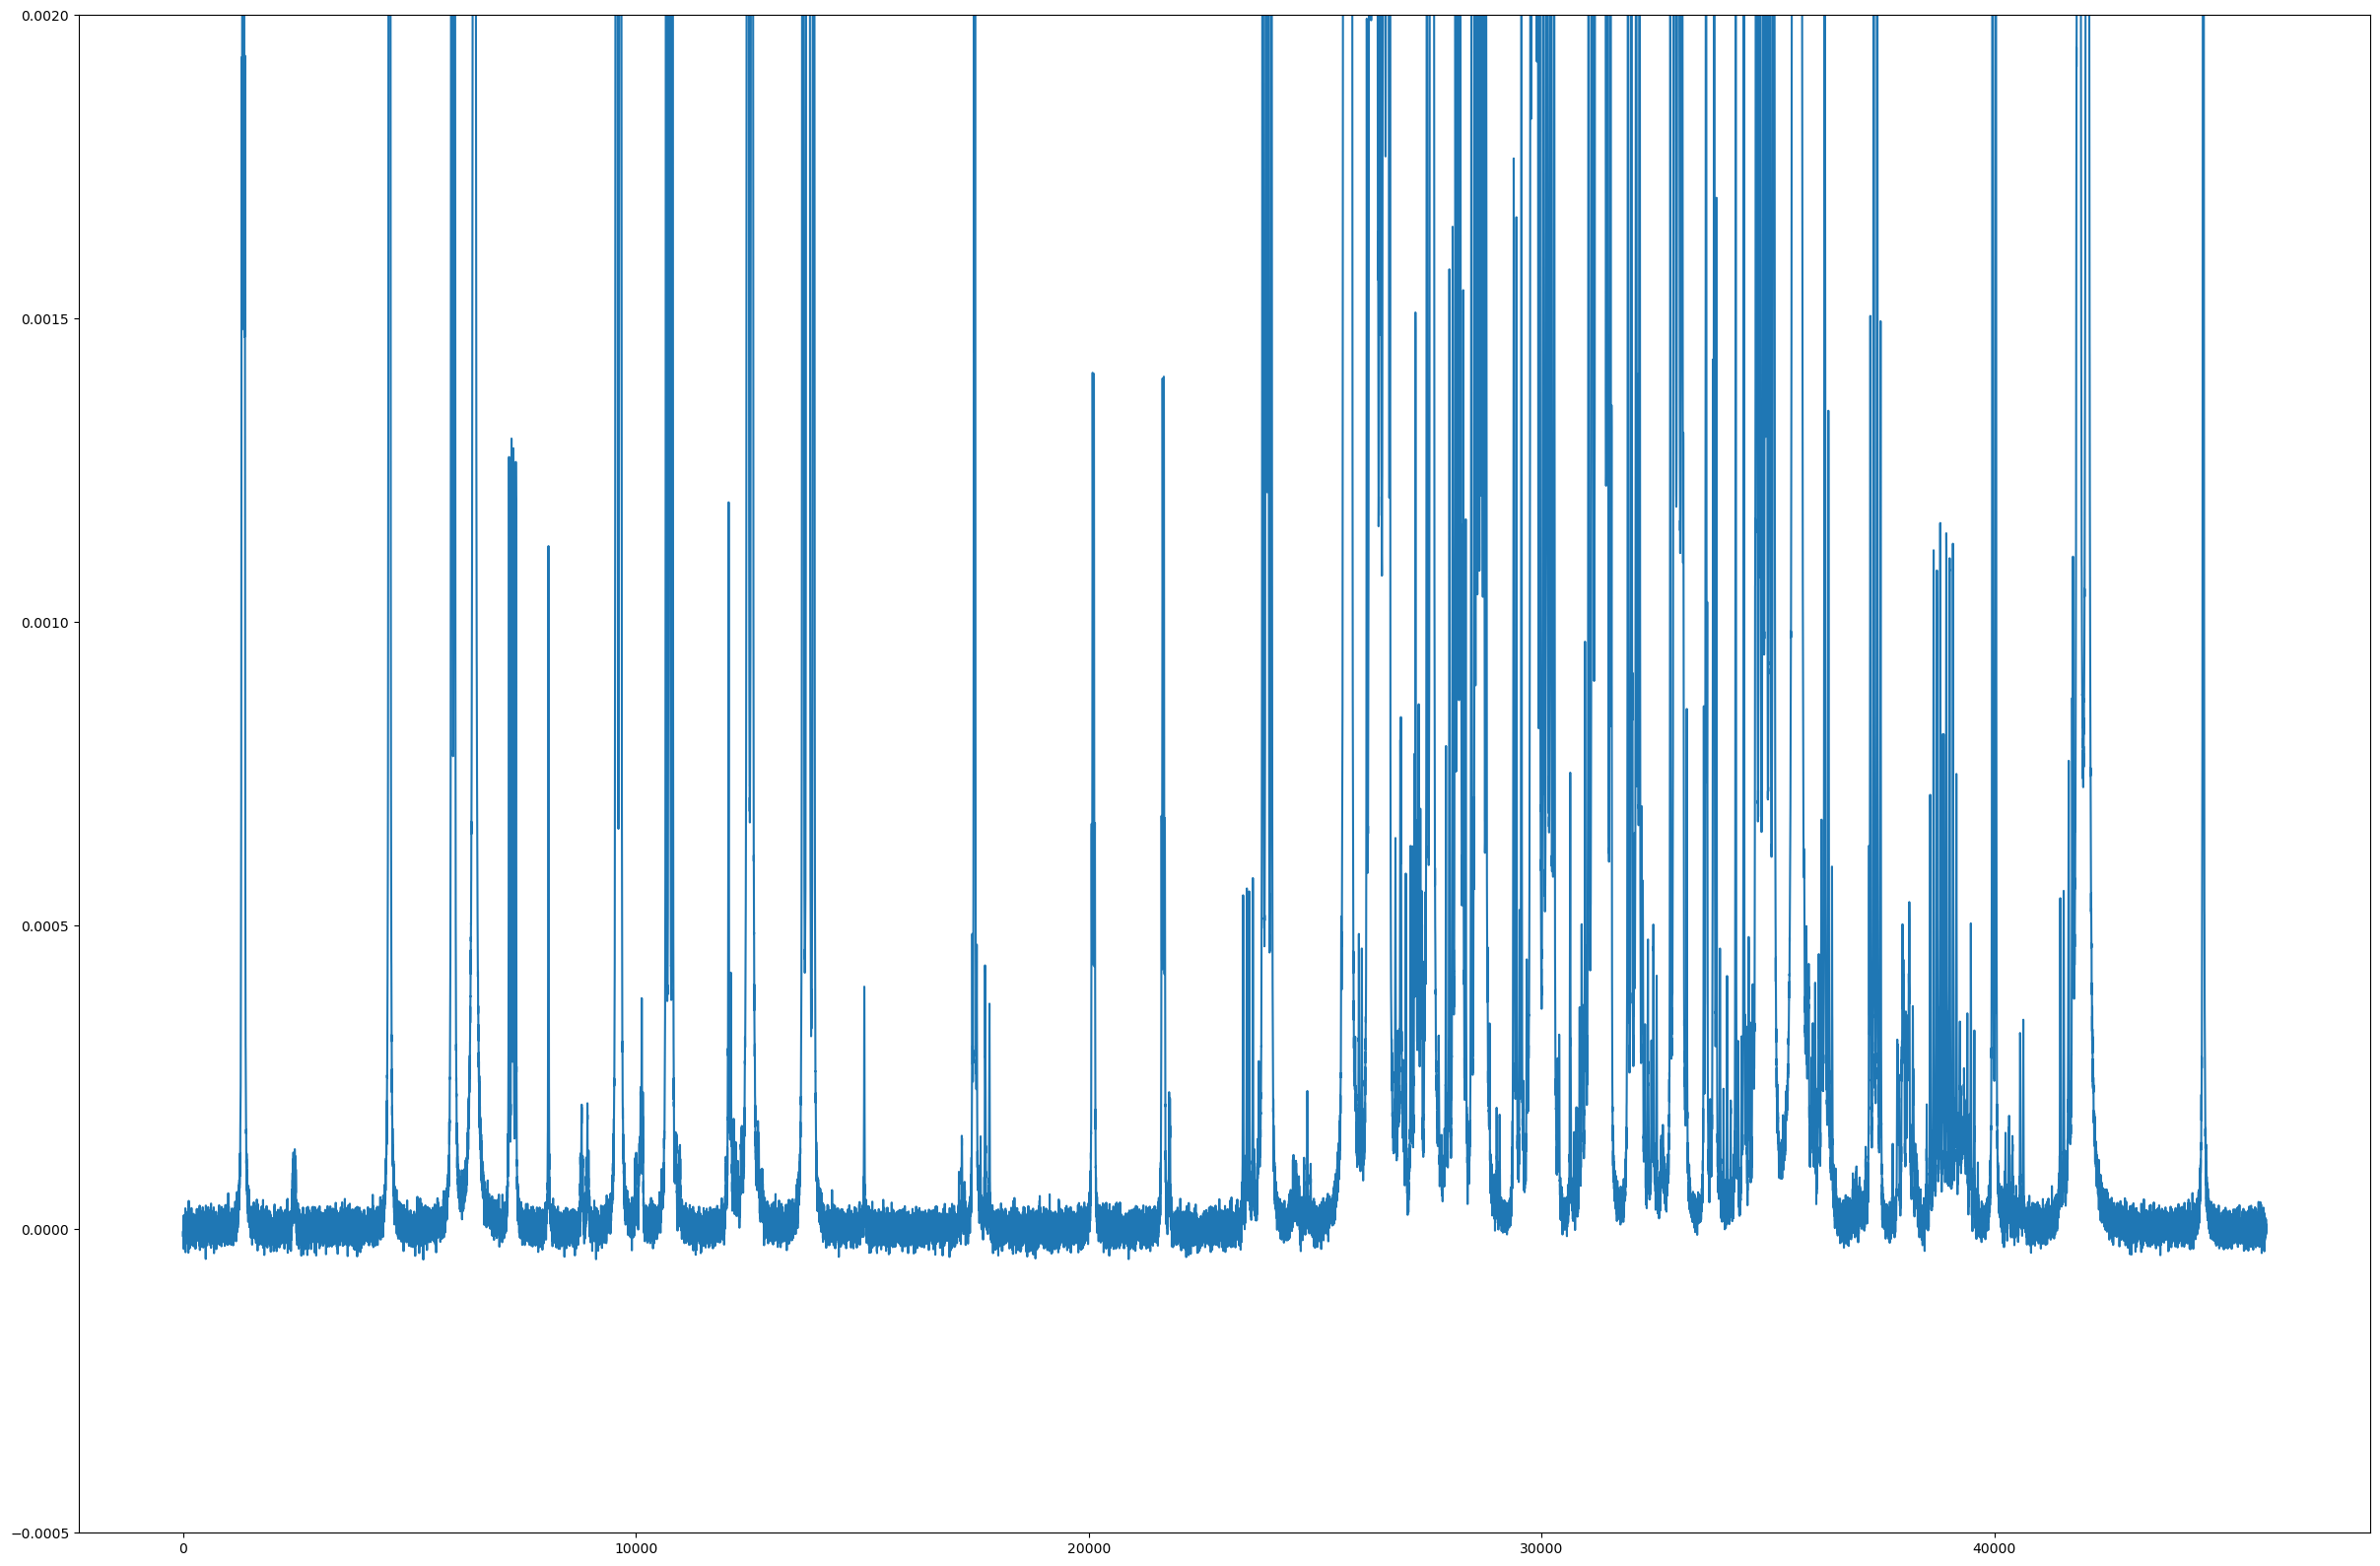

In [22]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [23]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  84.09862
--------------------
79.35  - Min Value: 0.013  - Mean Value: 0.6
85.5  - Min Value: 0.0115  - Mean Value: 0.4
86.29  - Min Value: 0.0115  - Mean Value: 0.4
86.22  - Min Value: 0.0115  - Mean Value: 0.6
89.63  - Min Value: 0.0115  - Mean Value: 1.0
83.74  - Min Value: 0.0115  - Mean Value: 1.1
80.73  - Min Value: 0.0115  - Mean Value: 0.8
80.48  - Min Value: 0.0115  - Mean Value: 0.5
85.6  - Min Value: 0.0115  - Mean Value: 0.5
83.43  - Min Value: 0.0115  - Mean Value: 1.1


In [24]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  79.79255
--------------------
81.78  - Min Value: 0.0062  - Mean Value: 2.1
85.15  - Min Value: 0.006  - Mean Value: 3.7
81.81  - Min Value: 0.0066  - Mean Value: 4.3
78.8  - Min Value: 0.0094  - Mean Value: 4.3
83.42  - Min Value: 0.0068  - Mean Value: 4.9
80.71  - Min Value: 0.005  - Mean Value: 3.8
77.43  - Min Value: 0.0101  - Mean Value: 3.2
76.35  - Min Value: 0.0062  - Mean Value: 3.2
76.35  - Min Value: 0.0053  - Mean Value: 5.3
76.12  - Min Value: 0.0054  - Mean Value: 2.5


In [25]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [26]:
model_aq(ConcSpec[5])

tensor([[0.0230, 0.0250, 0.0232, 0.0202, 0.0193, 0.0204, 0.0219, 0.0205, 0.0204,
         0.0216, 0.0241, 0.0170, 0.0169, 0.0220, 0.0189, 0.0220, 0.0251, 0.0226,
         0.0246, 0.0237, 0.0231, 0.0211, 0.0205, 0.0193, 0.0227, 0.0207, 0.0214,
         0.0197, 0.0229, 0.0197, 0.0173, 0.0201, 0.0188, 0.0168, 0.0217, 0.0237,
         0.0220, 0.0218, 0.0163, 0.0214, 0.0213, 0.0233, 0.0223, 0.0168]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [27]:
model_aq(SNR_Spec[1])

tensor([[0.0230, 0.0250, 0.0232, 0.0202, 0.0193, 0.0204, 0.0220, 0.0205, 0.0204,
         0.0216, 0.0241, 0.0170, 0.0169, 0.0220, 0.0189, 0.0220, 0.0251, 0.0227,
         0.0246, 0.0237, 0.0231, 0.0211, 0.0206, 0.0193, 0.0227, 0.0207, 0.0214,
         0.0197, 0.0229, 0.0196, 0.0173, 0.0201, 0.0189, 0.0168, 0.0216, 0.0237,
         0.0220, 0.0218, 0.0163, 0.0214, 0.0213, 0.0233, 0.0223, 0.0168]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  95.09762509885475
--------------------
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1


In [29]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  95.09799116769565
--------------------
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1


In [30]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  95.09716761075984
--------------------
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1
95.1


In [31]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.0229, 0.0249, 0.0231, 0.0202, 0.0192, 0.0204, 0.0218, 0.0204, 0.0204,
        0.0215, 0.0240, 0.0169, 0.0168, 0.0219, 0.0189, 0.0220, 0.0251, 0.0226,
        0.0246, 0.0237, 0.0231, 0.0211, 0.0205, 0.0193, 0.0227, 0.0207, 0.0213,
        0.0196, 0.0228, 0.0195, 0.0172, 0.0201, 0.0188, 0.0168, 0.0216, 0.0236,
        0.0219, 0.0217, 0.0163, 0.0214, 0.0212, 0.0232, 0.0222, 0.0167],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.0230, 0.0250, 0.0232, 0.0202, 0.0192, 0.0204, 0.0219, 0.0204, 0.0204,
        0.0215, 0.0241, 0.0169, 0.0169, 0.0220, 0.0189, 0.0220, 0.0251, 0.0226,
        0.0246, 0.0237, 0.0231, 0.0211, 0.0206, 0.0193, 0.0227, 0.0207, 0.0214,
        0.0197, 0.0228, 0.0195, 0.0172, 0.0201, 0.0188, 0.0168, 0.0216, 0.0237,
        0.0220, 0.0217, 0.0163, 0.0214, 0.0212, 0.0234, 0.0222, 0.0167],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a